In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from easymoney.money import EasyPeasy # For normalizing money
from dateutil import parser # for date conversion

import matplotlib.pyplot as plt
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline
from pprint import pprint

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, learning_curve, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest

#from common.CommonFunctions import train_and_eval

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [5]:
data_orig = pd.read_csv('./data/train.csv')

data = data_orig.copy()
data[['release_date']] = data_orig['release_date'].map(parser.parse)
data['release_year'] = pd.DatetimeIndex(data_orig['release_date']).year
data['release_month'] = pd.DatetimeIndex(data_orig['release_date']).month_name()
data['release_day'] = pd.DatetimeIndex(data_orig['release_date']).day_name()

# date parser interprets 21 to 68 as 2021 to 2068 --> fix
data.loc[data.release_year >= 2021, 'release_year'] = data.loc[data.release_year >= 2021, 'release_year'] - 100


In [6]:
# Off topic -> Normalize budget (remove inflation) -> basically no effect
def normalize_budget(ep, budget, region, from_year):
    region = region
    from_year = from_year
    to_year = "latest"
    base_currency = "USD"
    return int(ep.normalize(amount=budget, region=region, from_year=from_year, to_year=to_year, base_currency=base_currency))

# ep = EasyPeasy()
# data['norm_budget'] = data.apply(lambda row: normalize_budget(ep=ep, budget=row['budget'], region='USA', from_year=row['release_year']), axis=1)

In [7]:
tmp = data[['budget', 'release_year']][data.budget != 0]
median_budgets_per_year = tmp.groupby('release_year').agg(np.median).reset_index().rename(columns = {'budget': 'median_budget'})

In [8]:
tmp = data.merge(median_budgets_per_year, on=['release_year'], how='left')
data_filled = tmp.copy()
data_filled['budget'] = data_filled['budget'].replace(to_replace=0, value=data_filled['median_budget']).fillna(0)

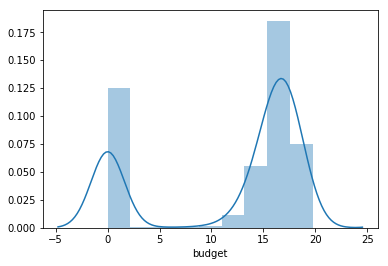

In [9]:
sns.distplot(np.log1p(data.budget))

In [10]:
sns.distplot(np.log1p(data_filled.budget))

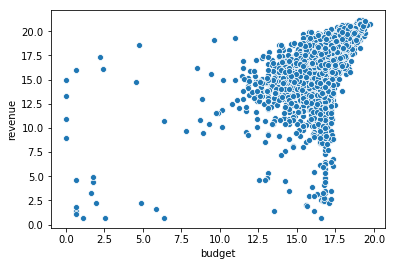

In [11]:
sns.scatterplot(np.log1p(data_filled.budget), np.log1p(data_filled.revenue))

In [12]:
np.corrcoef(np.log1p(data_filled.budget), np.log1p(data_filled.revenue))

array([[1.        , 0.43672347],
       [0.43672347, 1.        ]])

In [13]:
data_logged = np.log1p(data_filled[['budget', 'revenue']])

q75, q25 = np.percentile(data_logged.budget, [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*3)
max = q75 + (iqr*3)

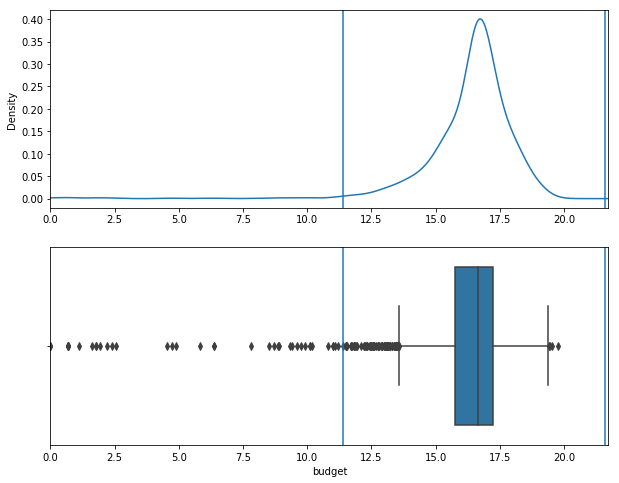

In [14]:
i = 'budget'
df = data_logged
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i])
plt.axvline(x=min)
plt.axvline(x=max)

In [15]:
print("Number of extreme outliers in budget: {}".format(len(data_filled[(np.log1p(data_filled.budget) > max) | (np.log1p(data_filled.budget) < min)])))

Number of extreme outliers in budget: 41
